## Model Creation

In [1]:
#file manipulation
import pandas as pd
import os
from glob import glob
import numpy as np
from PIL import Image

#neural network imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.layers import Input, Dense, Flatten
from keras.models import model_from_json

#hyperparameter fine-tuning

#ensemble imports

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#extra imports
from keras.utils import to_categorical
from tqdm import tqdm

In [2]:
#simply preparing the data
dataFolder = "C:\\Users\\leode\\Blood-Cancer_Data\\Official"
train = dataFolder + "\\train"
val = dataFolder + "\\validation"
test = dataFolder + "\\test"

tr_size, val_size, test_size = (
    len(glob(train + "/*")), len(glob(val + "/*")), len(glob(test + "/*"))
)

In [136]:
#a = glob(train + "/*")[0]
#img = Image.open(a)
img.size

(340, 270)

In [3]:
X_data = np.ones((tr_size, 270, 360, 3))
y_train = np.ones((tr_size,))
for i, P in tqdm(enumerate(glob(train + "/*"))):
    img = Image.open(P)
    X_data[i] = img.resize((360, 270))
    y_train[i] = int(P[-5])
X_data /= 255.
y_train = y_train.T


X_val = np.ones((val_size, 270, 360, 3))
y_val = np.ones((val_size,))
for i, P in tqdm(enumerate(glob(val + "/*"))):
    img = Image.open(P)
    X_val[i] = img.resize((360, 270))
    y_val[i] = int(P[-5])
X_val /= 255.
y_val = y_val.T

X_test = np.ones((test_size, 270, 360, 3))
y_test = np.ones((test_size,))
for i, P in tqdm(enumerate(glob(test + "/*"))):
    img = Image.open(P)
    X_test[i] = img.resize((360, 270))
    y_test[i] = int(P[-5])
X_test /= 255.
y_test = y_test.T

3383it [00:42, 79.32it/s] 
966it [00:12, 78.63it/s] 
485it [00:07, 67.88it/s] 


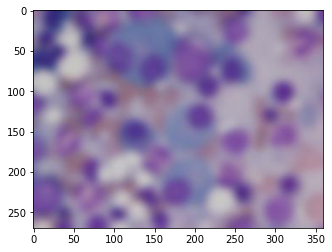

In [16]:
#though very basic, this function allows quick calls for displaying an image
def display(img: np.array):
    if img.ndim < 3:
        raise ValueError("Please input a 3 RBG channel image")
    plt.imshow(img)
    plt.show()

In [7]:
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

numpy.ndarray

In [73]:
#del(model)

In [4]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(270, 360, 3)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.1)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((3, 3)))
#     model.add(layers.AveragePooling2D((3, 3)))
#     model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    return model

#model = create_model()

In [5]:
model= create_model()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 268, 358, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 117, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 63936)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

In [6]:
print(X_data.shape)
print(y_train.reshape(-1,1).shape)

(1235, 270, 360, 3)
(1235, 1)


In [8]:
from keras import metrics

#loss should probably not be mean_squared_error
model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy",
              metrics=[
                  "accuracy",
                  metrics.MeanSquaredError(name='MSE'),
                  metrics.AUC(name='AUC'),
                  metrics.Precision(name='precision'),
                  metrics.Recall(name='recall'),
                  metrics.SensitivityAtSpecificity(specificity=0.5, name='s_at_spec')
              ])

In [9]:
#this code was copied from https://keras.io/guides/writing_your_own_callbacks/
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 268, 358, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 117, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6912)              0

In [11]:
history = model.fit(X_data, to_categorical(y_train), epochs=50,
                    verbose=2, callbacks=[EarlyStoppingAtMinLoss()], shuffle=False,
                    class_weight = {
                        0: 1.0,
                        1: 3.0,
                        2: 1.0,
                        3: 2.0,
                        4: 4.0,
                    },
                    validation_data=(X_val, to_categorical(y_val)),
                   )

Epoch 1/50
106/106 - 280s - loss: 2.1998 - accuracy: 0.5788 - MSE: 0.2021 - AUC: 0.7997 - precision: 0.3794 - recall: 0.7461 - s_at_spec: 0.8543 - val_loss: 0.9113 - val_accuracy: 0.6812 - val_MSE: 0.2118 - val_AUC: 0.8776 - val_precision: 0.3749 - val_recall: 0.9079 - val_s_at_spec: 0.9451
Epoch 2/50
106/106 - 241s - loss: 1.4543 - accuracy: 0.6417 - MSE: 0.2087 - AUC: 0.8689 - precision: 0.3757 - recall: 0.9276 - s_at_spec: 0.9876 - val_loss: 0.8109 - val_accuracy: 0.6905 - val_MSE: 0.2135 - val_AUC: 0.8901 - val_precision: 0.3847 - val_recall: 0.9224 - val_s_at_spec: 1.0000
Epoch 3/50
106/106 - 283s - loss: 1.3391 - accuracy: 0.6607 - MSE: 0.2255 - AUC: 0.8696 - precision: 0.3779 - recall: 0.9628 - s_at_spec: 0.9959 - val_loss: 0.8847 - val_accuracy: 0.6894 - val_MSE: 0.2487 - val_AUC: 0.8641 - val_precision: 0.3671 - val_recall: 0.9969 - val_s_at_spec: 0.9990
Epoch 4/50
106/106 - 292s - loss: 1.3194 - accuracy: 0.6680 - MSE: 0.2250 - AUC: 0.8761 - precision: 0.3796 - recall: 0.9669

KeyboardInterrupt: 

#### confusion matrix to visualize predictions based on class

In [32]:
#actual = y_test.copy()
#predicted = model.predict(X_test)
#predicted = [np.argmax(predicted[i]) for i in range(predicted.shape[0])]
np.array(predicted)

array([2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1,
       2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 1, 1, 3, 2,
       3, 3, 1, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 1,
       1, 1, 2, 1, 2, 1, 3, 1, 2, 2, 2, 2, 1, 4, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 4, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 3, 2, 2, 2, 2,
       2, 1, 2, 3, 2, 2, 1, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 1, 2,

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

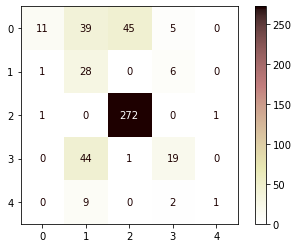

In [40]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True], )

cm_display.plot(cmap="pink_r", )
plt.title("Confusion Matrix on Test Images")
plt.show()
plt.savefig("conf_mat")

In [230]:
type(history.history)

dict

In [257]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'MSE', 'AUC', 'precision', 'recall', 's_at_spec', 'val_loss', 'val_accuracy', 'val_MSE', 'val_AUC', 'val_precision', 'val_recall', 'val_s_at_spec'])

##### Predefining all the matplotlib visual elements

In [424]:
# fig.set_figheight = 15
# fig.set_figwidth = 60
del(fig)
del(ax_top)
del(ax_bottom)

NameError: name 'ax_top' is not defined

Text(0.5, 0, 'Epoch')

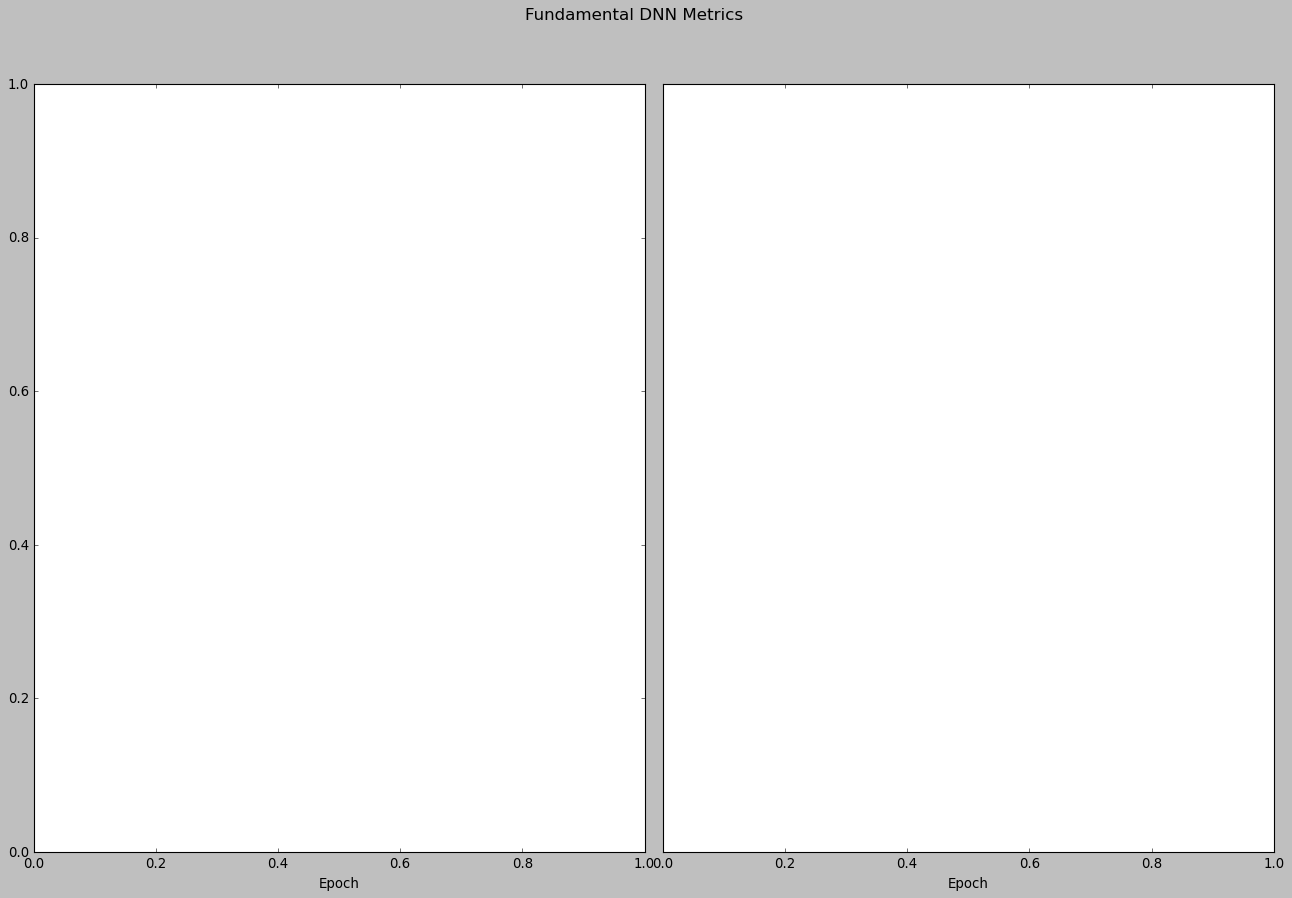

In [425]:
from matplotlib import style
import matplotlib as mpl
from cycler import cycler
plt.style.use('classic')

fig, (ax_top, ax_bottom) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle("Fundamental DNN Metrics", size=15)
fig.subplots_adjust(hspace=0, wspace=0.03)

mpl.rcParams["font.style"] = "normal"
mpl.rcParams["font.family"] = "monospace"
mpl.rcParams["lines.linewidth"] = 4
mpl.rcParams["lines.linestyle"] = '--' #override with most important line

ax_bottom.set_yticks([])
# ax_top.set_yticks_labels([0.0, 1.0])

ax_bottom.set_xlabel("Epoch")
ax_top.set_xlabel("Epoch")

In [322]:
metric_.keys()

dict_keys(['loss', 'accuracy', 'MSE', 'AUC', 'precision', 'recall', 's_at_spec', 'val_loss', 'val_accuracy', 'val_MSE', 'val_AUC', 'val_precision', 'val_recall', 'val_s_at_spec'])

In [426]:


metric_ = history.history.copy()
ax_top.plot(metric_["accuracy"], label='train_accuracy',)
ax_top.plot(metric_["val_accuracy"], label='val_accuracy', color="navy",
         marker=',', markersize=12)
ax_top.plot(metric_["loss"], label='train_loss', color="gray")
ax_top.plot(metric_["val_loss"], label='val_loss', color="black")

ax_top.legend(loc='center right')

ax_bottom.plot(metric_["val_AUC"], label='AUC')
ax_bottom.plot(metric_["val_precision"], label='precision', color="orange",
         marker=',', markersize=12)
ax_bottom.plot(metric_["val_recall"], label='recall')
ax_bottom.plot(metric_["val_s_at_spec"], label='sensitivity at specificity')

ax_bottom.legend(loc='lower right')

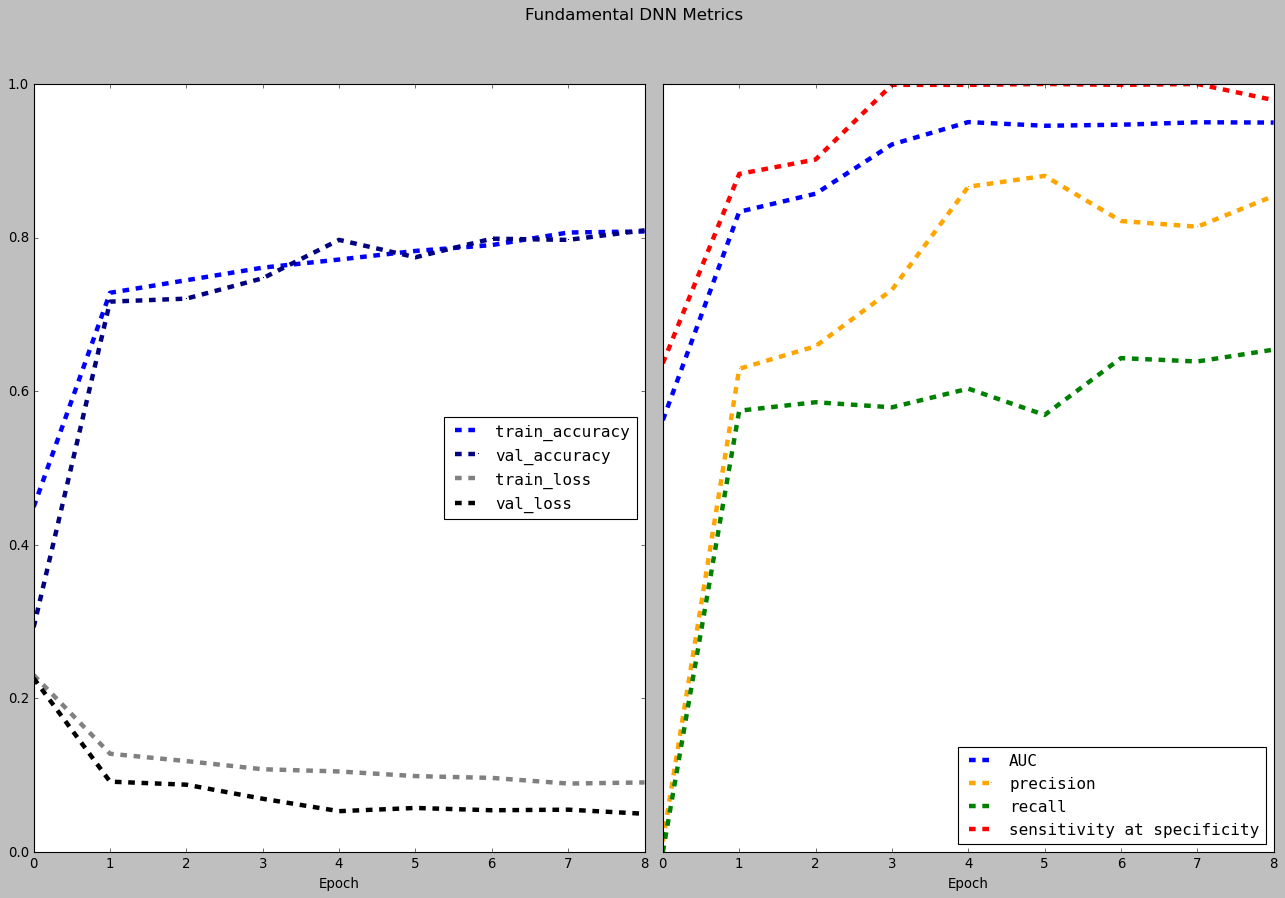

In [430]:
#fig.savefig("dcnn_metrics3.jpg")
#ax_top.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#fig

In [ ]:


plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [115]:
#y_pred = model.predict(X_test)
labels = ["Healthy", "Acute Lymphoblastic Leukemia",
          "Acute myeloid leukemia", "Multiple Myeloma", "Chronic Myeloid Leukemia"]

Predicted is Multiple Myeloma


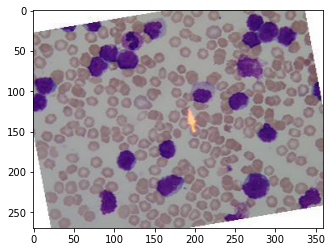

Actual is Healthy
__________________________________________________

Predicted is Acute Lymphoblastic Leukemia


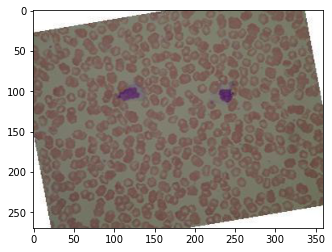

Actual is Acute Lymphoblastic Leukemia
__________________________________________________

Predicted is Multiple Myeloma


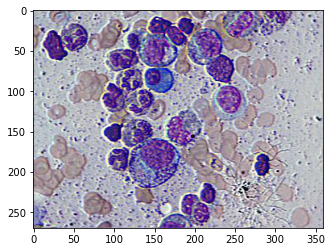

Actual is Multiple Myeloma
__________________________________________________

Predicted is Multiple Myeloma


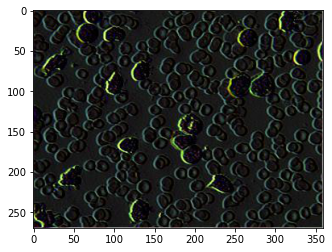

Actual is Acute Lymphoblastic Leukemia
__________________________________________________

Predicted is Multiple Myeloma


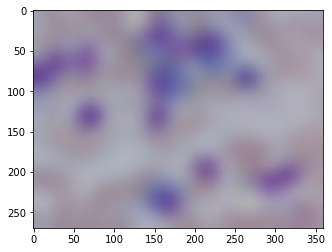

Actual is Multiple Myeloma
__________________________________________________

Predicted is Acute Lymphoblastic Leukemia


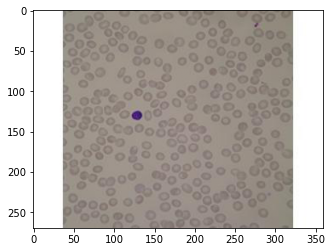

Actual is Healthy
__________________________________________________

Predicted is Acute Lymphoblastic Leukemia


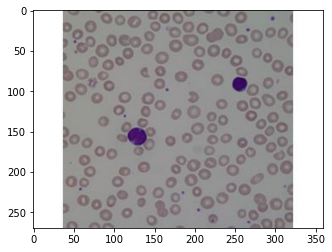

Actual is Acute Lymphoblastic Leukemia
__________________________________________________

Predicted is Multiple Myeloma


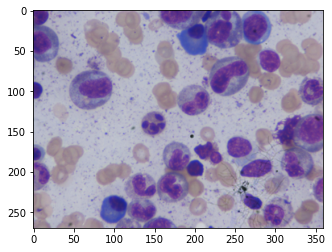

Actual is Multiple Myeloma
__________________________________________________

Predicted is Multiple Myeloma


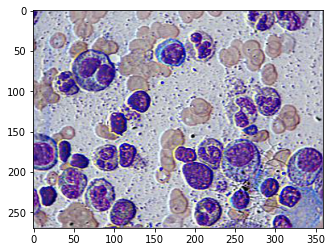

Actual is Multiple Myeloma
__________________________________________________

Predicted is Multiple Myeloma


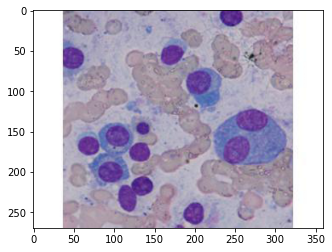

Actual is Multiple Myeloma
__________________________________________________



In [124]:
def testPred(i):
    print("Predicted is", labels[np.argmax(y_pred[i])])
    display(X_test[i])
    print("Actual is", labels[int(y_test[i])])
    print('_'*50)
    print()

for a in range(1, 60, 6):
    testPred(a)

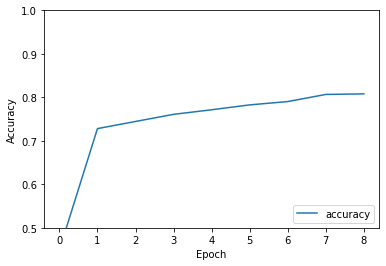

In [165]:
#y_pred = model.predict(X_test)
numZ = 0
for i in range(y_pred.shape[0]):
    if np.argmax(y_pred[100])==0:
        numZ += 1

##### Writing and saving the model

In [98]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model2.h5")
# print("Saved model to disk")

Saved model to disk


In [4]:
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [275]:
#loaded_model.evaluate(X_test, y_test)

In [6]:
loaded_model.predict(np.expand_dims(X_test[0], axis=0))

array([[4.6718214e-05, 5.3537974e-09, 9.9996233e-01, 6.2916490e-07,
        2.7082104e-08]], dtype=float32)

In [264]:
y_pred_loaded = loaded_model.predict(X_test)

## For Interpretive results, test on ANN

In [39]:
del(exp_test)

In [7]:
#this will be tested on different intepretive methods
def buildANN(down_shape):
    #(32, 72, 3) or (64, 108) is what the shape should probably be
    model = models.Sequential()
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu', input_shape=down_shape ))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))
    return model
exp_test = buildANN(down_shape=(64, 108))
#exp_test.summary()



In [8]:
#just smaller images for the dataset
X_data_down = np.ones((X_data.shape[0], 64, 108, 3))
X_val_down = np.ones((X_val.shape[0], 64, 108, 3))

In [10]:
for i, P in tqdm(enumerate(glob(train + "/*"))):
    img = Image.open(P)
    X_data_down[i] = img.resize((108, 64))
X_data_down /= 255.
for i, P in tqdm(enumerate(glob(val + "/*"))):
    img = Image.open(P)
    X_val_down[i] = img.resize((108, 64))
X_val_down /= 255.

3383it [00:23, 141.44it/s]
966it [00:05, 172.90it/s]


In [11]:
exp_test.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
print(X_data_down.shape)
print(to_categorical(y_train).shape)

(3383, 64, 108, 3)
(3383, 5)


In [12]:
exp_test.fit(X_data_down, to_categorical(y_train), epochs=5,
             verbose=2, shuffle=False,
             validation_data=(X_val_down, to_categorical(y_val)),)

Epoch 1/5
106/106 - 8s - loss: 1.7476 - accuracy: 0.5028 - val_loss: 0.4177 - val_accuracy: 0.5911
Epoch 2/5
106/106 - 3s - loss: 0.7105 - accuracy: 0.5454 - val_loss: 0.3839 - val_accuracy: 0.6781
Epoch 3/5
106/106 - 3s - loss: 0.4870 - accuracy: 0.5699 - val_loss: 0.3494 - val_accuracy: 0.6791
Epoch 4/5
106/106 - 3s - loss: 0.4078 - accuracy: 0.6086 - val_loss: 0.3460 - val_accuracy: 0.6822
Epoch 5/5
106/106 - 3s - loss: 0.3795 - accuracy: 0.6234 - val_loss: 0.3140 - val_accuracy: 0.6946


In [21]:
#exp_test.predict(np.expand_dims(X_data_down[0], axis=0) )


array([[0.2577265 , 0.17556879, 0.00759768, 0.62570566, 0.1184212 ]],
      dtype=float32)

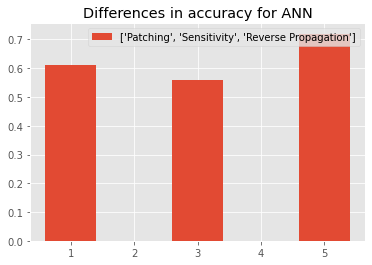

In [61]:
plt.style.use('ggplot')
plt.title("Differences in accuracy for ANN")
plt.bar([1, 3, 5], [0.61, 0.56, 0.72], label=["Patching", "Sensitivity", "Reverse Propagation"])
plt.legend()
plt.savefig("temp_img_fig")


### Method 1: Patching

In [22]:
#best to change the output visual to a heatmap or something
def patchImage(image, clf, window_size=(50,50)):
    pred_score = clf.predict(np.expand_dims(image, axis=0)) #should output five distinct float values
    idx = np.argmax(pred_score)
    patch_scores = np.full((image.shape[0], image.shape[1]), np.max(pred_score))
    PATCH = np.zeros((window_size[0], window_size[1], 3))
    row_end, col_end = window_size
    while row_end < image.shape[0]:
        while col_end < image.shape[1]:
            #the patch is applied to coordinates with row_end and col_end
            patched_img = image.copy() #to avoid corrupting the original image
            r1, r2, c1, c2 = (row_end-window_size[0], row_end, col_end-window_size[1], col_end)
            patched_img[r1:r2,c1:c2] = PATCH
#             plt.imshow(patched_img)
#             plt.show()
            #print("\n\n-----------------")
            p_score = np.max(clf.predict( np.expand_dims(patched_img, axis=0) ))
            patch_scores[r1:r2, c1:c2] = np.full(window_size, p_score)
            col_end += window_size[0]
            #print(p_score)
        col_end = window_size[0]
        row_end += window_size[1]
        
#     plt.imshow(image)
#     #but also display the significant values
#     plt.show()
#     plt.imshow(np.patch_scores)
    hmap = sns.heatmap(patch_scores)
    hmap.set_title("Confidence deviations after patching")
    hmap.set_xticks([])
    hmap.set_yticks([])
    sns.color_palette("light:#5A9", as_cmap=True)
    return patch_scores

array([[0.99996066, 0.99996066, 0.99996066, ..., 0.99996233, 0.99996233,
        0.99996233],
       [0.99996066, 0.99996066, 0.99996066, ..., 0.99996233, 0.99996233,
        0.99996233],
       [0.99996066, 0.99996066, 0.99996066, ..., 0.99996233, 0.99996233,
        0.99996233],
       ...,
       [0.99996233, 0.99996233, 0.99996233, ..., 0.99996233, 0.99996233,
        0.99996233],
       [0.99996233, 0.99996233, 0.99996233, ..., 0.99996233, 0.99996233,
        0.99996233],
       [0.99996233, 0.99996233, 0.99996233, ..., 0.99996233, 0.99996233,
        0.99996233]], dtype=float32)

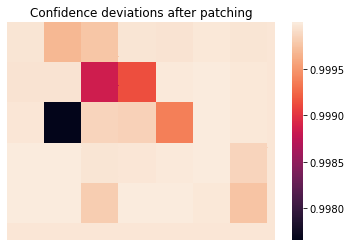

In [7]:
patchImage(X_test[0], loaded_model,)

In [8]:
# for A in range(200):
#     plt.title(A)
#     plt.imshow(X_test[A])
#     plt.show()

[]

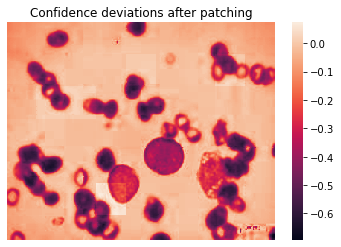

In [146]:
hmap = sns.heatmap(X_test[111][:, :, 0]-patch_scores)
hmap.set_title("Confidence deviations after patching")
hmap.set_xticks([])
hmap.set_yticks([])

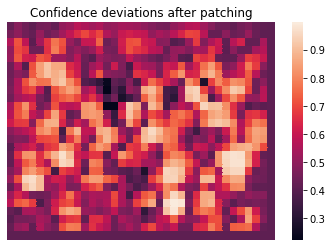

In [139]:
hmap = sns.heatmap(patch_scores)
hmap.set_title("Confidence deviations after patching")
hmap.set_xticks([])
hmap.set_yticks([])
plt.savefig("patch_map")

In [1]:
#loaded_model.predict(np.expand_dims(X_test[2], axis=0))
#patch_scores = patchImage(X_test[111], loaded_model, window_size=(40, 40))

In [2]:
# hmap = sns.heatmap(X_test[160][:, :, 0] - patch_scores, )
# hmap.set(xlabel="", ylabel="")
# hmap.set_xticks([])
# hmap.set_yticks([])

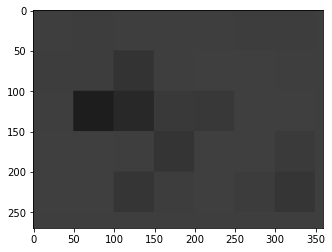

In [9]:
b = np.zeros(X_test[0].shape)
b[:, :, 0] = patch_scores
b[:, :, 1] = patch_scores
b[:, :, 2] = patch_scores
plt.imshow(b/4)

In [36]:
assert type(model.layers[-1]) == keras.layers.core.Dense

#### Evaluating the performance of patching

In [58]:
#X_data_down AND exp_test
#patched_i = patchImage(X_data_down[0], exp_test, window_size=(20, 20))
pimg = np.zeros((2, 64, 108, 3))
pimg[0, :, :, 0] = patched_i
pimg[0, :, :, 1] = patched_i
pimg[0, :, :, 2] = patched_i

In [60]:
exp_test.predict(np.expand_dims(pimg[0], axis=0))

array([[4.2408627e-01, 5.1411986e-04, 8.2073820e-01, 3.8402677e-03,
        1.6333818e-02]], dtype=float32)

In [ ]:
"""to test confidence, simply compare the following:
    *let Y = exp_test.predict(X_data_down[i]) WITH
    *let Y' = exp_test.predict(pimg[i])....
   Criteria can be based on avg difference of chosen values, in which if
   np.argmax(Y) != np.argmax(Y'), then push that to a queue Wr of wrong indexes
"""


### Method 2: Sensitivity Analysis

In [27]:
X_data.shape

(3383, 270, 360, 3)

In [41]:
#x_tensor
output

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[8.1612498e-02, 2.7181756e-01, 2.9569864e-04, 4.1266954e-01,
        2.3306036e-01]], dtype=float32)>

In [42]:
x_tensor = tf.convert_to_tensor(X_data[0:1], dtype=tf.float32)
with tf.GradientTape() as t:
    t.watch(x_tensor)
    output = loaded_model(x_tensor)

result = output
gradients = t.gradient(output, x_tensor)

In [106]:
# for i in range(100, 200):
#     a[i][100][2] = 0.0

In [105]:
# #a = X_img1[0].copy()
# a[105][100][2] = 0.3
# plt.imshow(a)

#### for reference, try changing gradients to gradients2 and notice the changes

In [133]:
###maybe compare the means of gradients2 and gradients in general
# gradients2
# np.mean(gradients)

6.614422e-06

In [130]:
#sample example of sensitivity analysis on the first input neuron
X_img1 = X_data[0:1].copy()

#pixel (treated as input layer neuron) to be changed
X_img1[0][100][100] = [0.0, 0.0, 0.0]

x_tensor = tf.convert_to_tensor(X_img1, dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(x_tensor)
    output = loaded_model(x_tensor)

result = output
gradients2 = t.gradient(output, x_tensor)

In [43]:
#gradients

<tf.Tensor: shape=(1, 270, 360, 3), dtype=float32, numpy=
array([[[[ 4.2036531e-06, -2.5469183e-06,  5.7250822e-06],
         [ 9.3781762e-07, -3.7990467e-06, -1.9198952e-08],
         [-3.2792980e-06, -2.4055487e-06,  2.2999775e-06],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[-7.7838075e-07,  7.5798687e-07,  9.2536686e-07],
         [-5.1415509e-06,  3.0417272e-07,  2.4690594e-06],
         [-1.2353041e-06, -9.9643148e-06,  6.4688656e-06],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 6.7655565e-06,  1.6924872e-06, -5.6567651e-06],
         [ 1.4525467e-06, -7.2636271e-06,  3.3314316e-06],
         [ 1.1599957e-06, -8.8630060e-07, -9.2919277e-07],
         ...,
         [ 

### Method 3: Layer-wise Relevant Propagation (give this a new name)

#### to find out the nodes of each layer, simply apply model.layers as a function

In [133]:
"""
1. create some function thay gets the idx of flattened layer
   ...and also make bool list of invalid layers (i.e. Dropout)
2. <insert here>
"""
firstLay = 6
ignoreLays = [8] #from indexes [currLay:-1]
#flattened_lay = np.zeros((6912, 1))
loaded_model.layers[firstLay]

In [103]:
#for i in loaded_model.layers[10].weights[0][:, 2].numpy(): print(i)

In [131]:
mp = {}
mp[2] = 3
mp[1] = 6
mp[3] = 13
mpOrder = sorted(mp, reverse=True)
for e in mpOrder:
    print(mp[e])

13
3
6


In [163]:
loaded_model.layers[7].weights[0][:, 4].numpy()

array([ 0.04056829,  0.00116535,  0.03104232, ...,  0.06890364,
       -0.08236814, -0.02982575], dtype=float32)

In [192]:
class RevProp:
    
    def __init__(self, model, startLay, ignoreLays):
        self.layers = model.layers
        self.endLay = startLay
        self.ignoreLay = ignoreLay
        
    """Things to not forget (checklist)
        * consider biases, which differ between answers
        * the call for weights is self.layers[currLay].weights[0][:, answer]
        * experiment on criteria for top Q in currLay (not simply highest values)
        * ...
    """
    def revprop(self, answer, currLay, Q):
        if currLay==self.endLay:
            #not sure what to return for base case
            return 0
            
        if currLay in self.ignoreLay: 
            self.revprop(answer, currLay-1, Q)
            return 0 #BUG FIXED
        
        highestVals = {}
        print(answer, "--->", currLay)
        weights = self.layers[currLay].weights[0][:, answer]
        for i, w in enumerate(weights.numpy()):
            highestVals[w] = i
            
        #sort by weights
        valOrder = sorted(highestVals, reverse=True)
        for A in range(Q):
            vkey = valOrder[A]
            #print(vkey, "---", highestVals[vkey], "---", currLay)
            self.revprop(highestVals[vkey], currLay-1, int(Q/2))
            
            
        
        
#already globaly defined in the notebook
revprop = RevProp(loaded_model, firstLay, ignoreLays)

In [193]:
#proper call of the algorithm
#revprop.revprop(answer=<>, currLay=<10/len_layers>, Q=<8 or so>)
revprop.revprop(2, 10, 8)

2 ---> 10
4 ---> 9
80 ---> 7
75 ---> 7
108 ---> 7
55 ---> 7
39 ---> 9
58 ---> 7
32 ---> 7
91 ---> 7
53 ---> 7
2 ---> 9
107 ---> 7
11 ---> 7
34 ---> 7
17 ---> 7
24 ---> 9
80 ---> 7
58 ---> 7
91 ---> 7
75 ---> 7
26 ---> 9
58 ---> 7
80 ---> 7
75 ---> 7
124 ---> 7
49 ---> 9
58 ---> 7
124 ---> 7
15 ---> 7
80 ---> 7
25 ---> 9
60 ---> 7
35 ---> 7
11 ---> 7
4 ---> 7
44 ---> 9
108 ---> 7
58 ---> 7
48 ---> 7
36 ---> 7


In [41]:
# model.layers[-1].weights

In [37]:
#tr = model.layers[0](x)
tr

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5260046 , 0.        , 0.        , 1.2108198 , 0.7888359 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 5.7150927 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.1664596 , 2.9661431 , 2.4307897 , 0.        , 0.        ,
        4.9043126 , 4.7842336 , 1.4039425 , 1.7586746 , 1.388057  ,
        0.        , 0.4947348 , 0.        , 2.558101  , 0.        ,
        0.        , 4.891385  , 0.        , 0.59604347, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.9892431 , 0.        , 0.        , 0.        ,
        2.6905565 , 0.04137333, 0.        , 0.        ]], dtype=float32)>

In [36]:
#x = np.expand_dims(X_test[0], axis=0)

for i in range(1, len(model.layers)-1):
    tr = model.layers[i](tr)

In [86]:
type(model.layers[-2]) == keras.layers.core.Dense

True

In [6]:
#time complexity for revprop is O(L*NEURONS_i*nm)
#where L is the number of Dense Layers, NEURONS_i is the number of neurons in layer -i,
#n and m are the number of rows/columns respectively.
class ReversePropagation:
    
    def __init__(self, data, labels, model, n_best):
        self.X = data
        self.y = labels
        self.layers = iter(model.layers)
        self.curr_layer = None
        self.dense_neurons = list() #per dense layer until output
        self.model = model
        self.firstDense()
        
        #new top-level class variables used
        self.Q = n_best #number of paths per recursive call
        self.flattened_lay = np.zeros((6912, 1)) #maybe make this of ones for relative scaling
        
        
    #####Why does this function's call take SO LONG!
    #apply nn functions until reaching first Dense layer
    def firstDense(self):
        #in the acutal website, this needs to be saved in some file...
        if self.X.ndim <= 3:
            self.X = np.expand_dims(self.X, axis=0)
        self.curr_layer = tf.Variable(self.X, dtype=tf.float32)
        operation = None
        while type(operation) not in [keras.layers.core.Dense, keras.layers.core.Flatten]:
            operation = next(self.layers)
            self.curr_layer = operation(self.curr_layer)
        try:
            while True:
                self.dense_neurons.append(self.curr_layer)
                self.curr_layer = next(self.layers)(self.curr_layer)
        except StopIteration: pass
        finally: print("finished getting the neuron values for Dense layers!")
    
    #the main functionality of this class... ...make sure to apply recursion
    def revprop(self, idx, answer):
        a_js = None
        
        #where answer is the correct output for this image
        for i in range(1, len(self.dense_neurons)):
            i = -1*i
            if type(self.model.layers[i]) == keras.layers.core.Dropout: continue
            #apply the operations of layers at both idx and idx-1
            a_k = self.dense_neurons[i].numpy()[idx][answer] #a_k is always one value!
            #iterate through each prev. neuron
            a_js = list() #later convert into a numpy array
            sum_w = np.sum(self.model.layers[i].weights[0].numpy()[:, answer])
            print("Once below gets to", prop.dense_neurons[i-1].numpy()[idx].shape[0], "---> then done")
            for r, NEURON in tqdm(enumerate(self.dense_neurons[i-1].numpy()[idx])):
                w_j = self.model.layers[i].weights[0].numpy()[r, answer]
                a_js.append( (w_j/sum_w)*a_k )
            a_js = np.array(a_js)
            answer = np.argmax(a_js) #remember, this is a  linear search, so further optimization may be needed
            #revprop(idx, answer)
            
        return a_js
    
    
    #flattened_lay--> shape (6912,1) of zeroes
    #curr_flattened_lay = self.model.layers[-len(self.dense_neurons)+1].weights[0][:, answer].numpy()
    def revprop2(self, idxImg, answer, i, Q):
        if i==-len(self.dense_neurons)+1:
            #base case at input layer, or, just before the first Dense
            #make a connection of answer to each input neuron
            #flattened_lay += curr_flattened_lay #each value in curr_f should be added to flattened
            self.flattened_lay += self.model.layers[-len(self.dense_neurons)+1].weights[0][:, answer].numpy()
            return 0
        if type(self.model.layers[i]) == keras.layers.core.Dropout:
            i -= 1
        a_k = self.dense_neurons[i].numpy()[idxImg][answer] #a_k is always one value!
        a_js = dict()
        sum_w = np.sum(self.model.layers[i].weights[0].numpy()[:, answer])
        bias_term = self.model.layers[-1].bias[2].numpy()
        for r, NEURON in tqdm(enumerate(self.dense_neurons[i-1].numpy()[idxImg])):
            w_j = self.model.layers[i].weights[0].numpy()[r, answer]
            #a_js.append( (w_j/sum_w)*a_k + bias_term )
            a_js[ (w_j/sum_w)*a_k + bias_term ] = NEURON
        #now just take the top Q values
        a_js_id = sorted(a_js)
        for q in range(1, Q+1):
            self.revprop2(idxImg, a_js[a_js_id[-q]], i-1, Q/2)
    
    #given a flattened image, reconstruct correctly
    def unflatten(self, img):
        pass
            
        
prop = ReversePropagation(X_test, y_test, loaded_model, 8)


finished getting the neuron values for Dense layers!


In [23]:
prop.revprop(0, 2)

64it [00:00, 3198.17it/s]

Once below gets to 64 ---> then done
Once below gets to 128 ---> then done



128it [00:00, 894.09it/s]
14it [00:00, 109.26it/s]

Once below gets to 6912 ---> then done


6912it [02:03, 55.80it/s] 


array([-0.00095964, -0.00069748, -0.00146147, ..., -0.00061236,
        0.00031316, -0.00156807], dtype=float32)

In [168]:
flattened_lay

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

### Make sure to consider acutal values for revprop, not just weights

In [10]:
#from keras import backend as K

#The layer number
n = 3 
# with a Sequential model
# get_nth_layer_output = K.function([prop.model.layers[0].input],
#                                   [prop.model.layers[n].output])
# get_nth_layer_output(X_data)#([X])[0]

In [12]:
#prop.model.layers[-4].weights[0]#[6911, :]  #[:, 6911].numpy()
len(prop.dense_neurons)

5

In [21]:
flattened_lay = np.zeros((6912, 1))


def revprop2(idxImg, answer, i, Q, a_js, a_js_id):
    global flattened_lay
    #print(i)
    if i==-5:
        #base case at input layer, or, just before the first Dense
        #make a connection of answer to each input neuron
        #flattened_lay += curr_flattened_lay #each value in curr_f should be added to flattened
        #flattened_lay += prop.model.layers[-len(prop.dense_neurons)+1].weights[0][:, answer].numpy()
        print(-len(prop.dense_neurons)+1)
        print(answer)
        flattened_lay[answer]+=1 #temporary!
        return 0
    if type(prop.model.layers[i]) == keras.layers.core.Dropout:
        i -= 1
    a_k = prop.dense_neurons[i].numpy()[idxImg][answer] #a_k is always one value!
    a_js = dict()
    print(f"idx={idxImg}; answer={answer}; i={i}; Q={Q}\n")
    sum_w = np.sum(prop.model.layers[i].weights[0].numpy()[:, answer])
    bias_term = prop.model.layers[-1].bias[2].numpy()
    print("This ends at", len(prop.dense_neurons[i-1].numpy()[idxImg]), "iterations")
    for r, NEURON in tqdm(enumerate(prop.dense_neurons[i-1].numpy()[idxImg])):
        w_j = prop.model.layers[i].weights[0].numpy()[r, answer]
        #a_js.append( (w_j/sum_w)*a_k + bias_term )
        a_js[ (w_j/sum_w)*a_k + bias_term ] = r #to r, not NEURON!

    #now just take the top Q values
    a_js_id = sorted(a_js)
    #main problem with this: a_js is updated per recursive call
    for q in range(1, Q+1):
        #print(int(a_js[a_js_id[-q]]))
        #print(a_js_id[-q])
        print(f"Recursive call: {a_js}; i={i}; q={q}")
        revprop2(idxImg, int(a_js[a_js_id[-q]]), i-1, int(Q/2), a_js, a_js_id)
    #revprop2(idxImg, int(a_js[a_js_id[-1]]), i-1, int(Q/2), a_js)

revprop2(0, 2, -1, 16, None, None)

0it [00:00, ?it/s]

idx=0; answer=2; i=-1; Q=16

This ends at 64 iterations


64it [00:00, 999.76it/s]
128it [00:00, 1776.48it/s]


Recursive call: {-0.09729228: 0, -0.061029203: 1, -0.19785737: 2, -0.16223064: 3, -0.20898736: 4, -0.0977542: 5, -0.15997462: 6, -0.17349857: 7, -0.07633118: 8, -0.11777039: 9, -0.14605764: 10, -0.15362328: 11, -0.121286914: 12, -0.01778438: 13, -0.14599459: 14, -0.13994667: 15, -0.097229175: 16, -0.14966106: 17, -0.11834429: 18, 0.0075600445: 19, -0.17001703: 20, -0.100274764: 21, -0.14608496: 22, -0.1762858: 23, -0.19362178: 24, -0.18750732: 25, -0.19125918: 26, -0.16473213: 27, -0.15416987: 28, -0.15825216: 29, -0.06308823: 30, -0.13277216: 31, -0.124786064: 32, -0.12916692: 33, -0.15246545: 34, -0.08794229: 35, -0.12964451: 36, -0.13055708: 37, -0.035788827: 38, -0.20682819: 39, -0.1635815: 40, -0.033678904: 41, -0.07425797: 42, -0.023961939: 43, -0.18706055: 44, -0.13729778: 45, -0.1588098: 46, -0.051728815: 47, -0.15289326: 48, -0.19114536: 49, -0.14456162: 50, -0.09706863: 51, -0.09398542: 52, -0.041357793: 53, -0.10224201: 54, -0.16803561: 55, -0.082908794: 56, -0.14843474: 57,

0it [00:00, ?it/s]

This ends at 6912 iterations


6912it [02:56, 39.14it/s]


Recursive call: {-0.1424525: 6911}; i=-4; q=1
-4
6911
Recursive call: {-0.1424525: 6911}; i=-4; q=2


IndexError: list index out of range

In [17]:
flattened_lay

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [14]:
prop.model.layers[-4].weights#[0].numpy()#[:, answer])

[<tf.Variable 'dense/kernel:0' shape=(6912, 128) dtype=float32, numpy=
 array([[-0.03735568, -0.0110524 , -0.03266157, ...,  0.00356219,
         -0.00983708, -0.07182347],
        [-0.02715086, -0.01306163, -0.00736149, ...,  0.00260322,
          0.04472937, -0.03374924],
        [-0.05689027, -0.00907305,  0.02235492, ..., -0.05835415,
          0.00523975, -0.02104619],
        ...,
        [-0.02383713, -0.01995077,  0.01469783, ...,  0.01472892,
         -0.05046083, -0.00764098],
        [ 0.01219038, -0.03814203, -0.0307373 , ..., -0.02226964,
          0.0262191 , -0.05289169],
        [-0.06103998,  0.02302913, -0.03280298, ..., -0.0253908 ,
         -0.00979209, -0.01254407]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 0.02130715, -0.02504463,  0.00228961, -0.00631249,  0.00272941,
        -0.01451301,  0.01651235, -0.00857787, -0.05248059,  0.00913031,
         0.01901506, -0.03944814, -0.03165268, -0.00593147,  0.0030366 ,
   

In [7]:
#prop.revprop2(0, 2, -1, 8)

2.0

#### temporary copying to make this recursive

In [79]:
len(prop.dense_neurons)

5

In [97]:
prop.model.layers[-4].weights[0][:, 10].numpy()

array([ 0.08215139,  0.00539782, -0.06419086, ..., -0.07145507,
       -0.03585598, -0.0782204 ], dtype=float32)

In [68]:
flattened_lay = np.zeros((6912, 1))
#revprop(0, 2, -1)


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
#flattened_lay--> shape (6912,1) of zeroes
#curr_flattened_lay = self.model.layers[-len(self.dense_neurons)+1].weights[0][:, answer].numpy()
def revprop(self, idxImg, answer, i, Q):
    if i==-len(self.dense_neurons)+1:
        #base case at input layer, or, just before the first Dense
        #make a connection of answer to each input neuron
        flattened_lay += curr_flattened_lay #each value in curr_f should be added to flattened
        return 0
    if type(self.model.layers[i]) == keras.layers.core.Dropout: i -= 1
    a_k = self.dense_neurons[i].numpy()[idxImg][answer] #a_k is always one value!
    a_js = dict()
    sum_w = np.sum(self.model.layers[i].weights[0].numpy()[:, answer])
    bias_term = prop.model.layers[-1].bias[2].numpy() #of course, bias[2] should be variable
    for r, NEURON in tqdm(enumerate(self.dense_neurons[i-1].numpy()[idxImg])):
        w_j = self.model.layers[i].weights[0].numpy()[r, answer]
        #a_js.append( (w_j/sum_w)*a_k + bias_term )
        a_js[ (w_j/sum_w)*a_k + bias_term ] = NEURON
    #now just take the top Q values
    a_js_id = sorted(a_js)
    for q in range(1, Q+1):
        self.revprop(idxImg, a_js[a_js_id[-q]], i-1, Q/2)

#call: revprop(0, 2, -1)

"""
def revprop(self, idx, answer):
    a_js = None

    #where answer is the correct output for this image
    for i in range(1, len(self.dense_neurons)):
        i = -1*i
        if type(self.model.layers[i]) == keras.layers.core.Dropout: continue
        #apply the operations of layers at both idx and idx-1
        a_k = self.dense_neurons[i].numpy()[idx][answer] #a_k is always one value!
        #iterate through each prev. neuron
        a_js = list() #later convert into a numpy array
        sum_w = np.sum(self.model.layers[i].weights[0].numpy()[:, answer])
        print("Once below gets to", prop.dense_neurons[i-1].numpy()[idx].shape[0], "---> then done")
        for r, NEURON in tqdm(enumerate(self.dense_neurons[i-1].numpy()[idx])):
            w_j = self.model.layers[i].weights[0].numpy()[r, answer]
            a_js.append( (w_j/sum_w)*a_k )
        a_js = np.array(a_js)
        answer = np.argmax(a_js) #remember, this is a  linear search, so further optimization may be needed
        #revprop(idx, answer)

    return a_js
"""

In [65]:
#prop.dense_neurons[-5]
prop.model.input

<KerasTensor: shape=(None, 270, 360, 3) dtype=float32 (created by layer 'conv2d_input')>

In [51]:
#a_k = prop.dense_neurons[-1].numpy()[0][2]
#sum_w `= np.sum(prop.model.layers[-1].weights[0].numpy()[:, 2])
#bias_term = prop.model.layers[-1].bias[2].numpy()

#np.sum(prop.model.layers[-1].weights[0].numpy()[:, 2])
#prop.model.layers[-4].bias[2].numpy()

0.0022896128

In [50]:
a_js = prop.revprop(34, 2)

64it [00:00, 4119.19it/s]
128it [00:00, 5331.50it/s]
0it [00:00, ?it/s]

Once below gets to 64 ---> then done
Once below gets to 128 ---> then done
Once below gets to 6912 ---> then done


6912it [00:16, 431.09it/s]


In [67]:
a = np.ones((64, 108, 3))
a[:, :, 0] = a_js.reshape(64, 108)
a[:, :, 1] = a_js.reshape(64, 108)
a[:, :, 2] = a_js.reshape(64, 108)

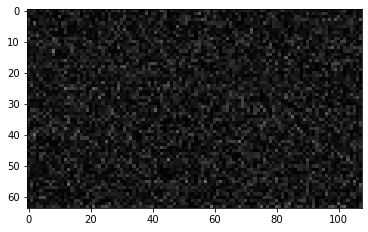

In [83]:
plt.imshow(abs(a)*255)

In [79]:
prop.dense_neurons[-5].numpy()[idx].shape

(63936,)

In [80]:
idx = 0
answer = 3

for i in range(1, len(prop.dense_neurons)):
    i = -1*i
    if type(prop.model.layers[i]) == keras.layers.core.Dropout:
        print(i)
        continue
    #apply the operations of layers at both idx and idx-1
    a_k = prop.dense_neurons[i].numpy()[idx][answer] #a_k is always one value!
    #iterate through each prev. neuron
    a_js = list() #later convert into a numpy array
    sum_w = np.sum(prop.model.layers[i].weights[0].numpy()[:, answer])
    print("Once below gets to", prop.dense_neurons[i-1].numpy()[idx].shape[0], "---> then done")
    for r, NEURON in tqdm(enumerate(prop.dense_neurons[i-1].numpy()[idx])):
        w_j = prop.model.layers[i].weights[0].numpy()[r, answer]
        a_js.append( (w_j/sum_w)*a_k )
    a_js = np.array(a_js)
    
    answer = np.argmax(a_js) #remember, this is a  linear search, so further optimization may be needed
    

64it [00:00, 7980.84it/s]
128it [00:00, 5316.76it/s]

Once below gets to 63936 ---> then done
Once below gets to 63936 ---> then done
-3
Once below gets to 63936 ---> then done



63936it [15:14, 69.95it/s]


IndexError: list index out of range

In [85]:
a_js

[]

In [81]:
prop.model.layers[i].weights[0].numpy()[:, answer]

IndexError: list index out of range

In [25]:
a_js.shape

(64,)

In [129]:
a_js = prop.revprop(0, 3)

KeyboardInterrupt: 

In [116]:
#ans
#a_k = prop.dense_neurons[-2].numpy()[0][ans]
np.sum(prop.model.layers[-2].weights[0].numpy()[:, ans])

1082.2714

In [118]:
# prop.model.layers[-2].weights

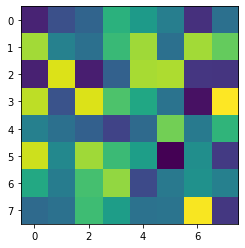

In [94]:
plt.imshow(np.array(a_js).reshape(8, 8))

In [90]:
a_js = prop.revprop(0, 3)

In [86]:
prop.model.layers[-1].weights[0].numpy()[0, 3]

-0.2364898

In [66]:
sum_w = np.sum(prop.model.layers[-1].weights[0].numpy()[:, 3])
for r in prop.dense_neurons[-2].numpy()[0]:
    w_j = prop.model.layers[-1].weights[]

0.11740261

In [45]:
np.sum(prop.model.layers)

12.994119

In [28]:
#pretend the data is X_test, y_test
# X_test.shape -> (178, 270, 360, 3)
model = tf.nn.conv2d(
    tf.Variable(X_test, dtype=tf.float32), tf.Variable(filters, dtype=tf.float32),
    [1, 1, 1, 1], "SAME"
)

In [44]:
tf.nn.pool

<function tensorflow.python.ops.nn_ops.pool_v2(input, window_shape, pooling_type, strides=None, padding='VALID', data_format=None, dilations=None, name=None)>

In [57]:
#model.numpy

In [66]:
model_pool = tf.nn.pool(model, [30, 30], "MAX")

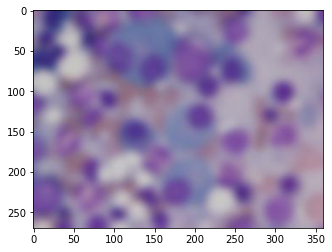

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


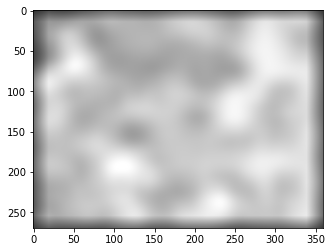

In [43]:
plt.imshow(X_test[0])
plt.show()
plt.imshow(model[0]/2555)

In [84]:
#this class I wrote does not come with ANN flattening
class Custom_CNN:
    
    def __init__(self, images):
        assert images.ndim >= 4
        self.curr_layer = images
        self.weights = None #only applicable to last ANN layer
        self.bias = 10
    
    #requires arguments 'filters' (4D tensor) and 'strides' (list)
    def addConv(self, filters, strides, padding="SAME", activation="relu", **kwargs):
        conv_lay = tf.nn.conv2d(self.curr_layer, filters,
                                strides, padding)
        conv_lay += self.bias
        if activation.lower() == "relu":
            conv_lay = tf.nn.relu(conv_lay)
        else:
            #sigmoid is likely the only other viable function
            pass
    
    #simply decrease input size
    def pooling(self, window_size, stride, kind="max"):
        if "max" in kind.lower():
            pool_lay = tf.nn.max_pool(self.curr_layer, ksize=window_size,
                                      strides=stride, padding='SAME')
        else:
            #perform average pooling operation on the curr. layer
            pass
        
        
    def defineParams(self, W, B):
        self.weights = W
        self.bias = B
    

In [86]:
filter1 = np.ones((270, 360, 3, 3))
stride1 = [1, 1, 1, 1]

In [ ]:
# def ConvNet1(image):        
#     conv1 = tf.nn.conv2d(input=image, filters=conv1_weights,        strides=conv_stride, padding='SAME')     
#     conv1+=bias_1     
#     conv1 = tf.nn.relu(conv1)     
#     conv1 = tf.nn.max_pool(input=conv1, ksize=window_size, strides=window_stride, padding='SAME')     
#     return conv1

In [ ]:
class CNN_Block:
    
    def __init__(self, data):
        self.data = data #a 4D numpy array
        self.filters = []
        self.idx = 0
    
    def addConv2D(self, *args):
        #input, filters, strides, padding
        cnn_i = tf.nn.conv2d(
            self.data[self.idx], 
        )
    
    

In [94]:
data = np.random.randn(3, 3, 3) * np.random.randn(3, 3, 3)
X = np.expand_dims(data, axis=0)
# plt.imshow(X[0])

In [121]:
block.call(input_tensor=np.array(X), training=False)

<tf.Tensor: shape=(1, 3, 3, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.05539945],
         [0.        , 0.        , 0.01412675],
         [0.2699722 , 0.84461904, 0.17338362]],

        [[0.        , 0.        , 0.        ],
         [0.9981478 , 0.        , 0.        ],
         [0.6539958 , 0.21216625, 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.6804672 , 0.        ],
         [0.        , 2.284418  , 0.4337881 ]]]], dtype=float32)>

In [96]:
block.weights

[<tf.Variable 'conv2d_3/kernel:0' shape=(1, 1, 3, 1) dtype=float32, numpy=
 array([[[[-0.5200741 ],
          [ 0.61169386],
          [-0.34894145]]]], dtype=float32)>,
 <tf.Variable 'conv2d_3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'batch_normalization_3/gamma:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Variable 'batch_normalization_3/beta:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'batch_normalization_3/moving_mean:0' shape=(1,) dtype=float32, numpy=array([0.00400226], dtype=float32)>,
 <tf.Variable 'batch_normalization_3/moving_variance:0' shape=(1,) dtype=float32, numpy=array([1.0047365], dtype=float32)>,
 <tf.Variable 'conv2d_4/kernel:0' shape=(1, 1, 1, 2) dtype=float32, numpy=array([[[[ 0.65410936, -0.25414753]]]], dtype=float32)>,
 <tf.Variable 'conv2d_4/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization_4/gamma:0' shape

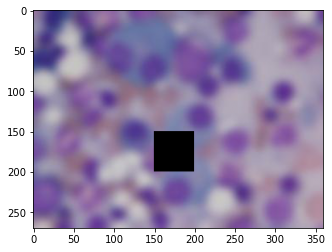